In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import scipy.stats as ss
import collections
import corner
import seaborn as sns
import random
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

In [3]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance),average

In [4]:
#df=pd.read_csv("NED27.02.1-D-14.1.0-20170227.csv",skiprows=12)
#df=df[np.isnan(df['redshift (z)'])] # only measurements without redshift data are useful here

In [4]:
df=pd.read_csv("NED27.09.1-D-14.2.0-20170929.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])] # only measurements without redshift data are useful here

In [5]:
def selectdata_lite(mymethod,df):
    dfa=df[~np.isfinite(df.err)] # database of non reported errors
    df1=df[np.isfinite(df.err)] # remove measurements that do not report an error
    df1=df1[df1.err!=0] # remove measurements that report an error as zero ¬¬
# Select a method for analysis
    df1=df1[df1.Method==mymethod] # choose a method
    namelist=list(df1['Galaxy ID']) # list of galaxies
    counter=collections.Counter(namelist) # count measurements per galaxy
# Select galaxies with a minimum number of measurements
    ulist=[]
    ulist2=[]
    nmeas=1
    for i in counter.keys():
        if counter[i]>nmeas:
            ulist+=[i] # all galaxies with more than n_meas measurements
        if counter[i]>=1:
            ulist2+=[i] # all galaxies with at least one measurement w/a reported error
    print('No. of Galaxies with reported errors is %i' % len(ulist2) )
    print('No. of Galaxies with more than %i measurements is %i' % (nmeas,len(ulist)) )
# Create database for bootstrap, remove unnecessary columns
    dfs=df1[np.in1d(df1['Galaxy ID'],ulist)] # dataframe with galaxies with more than nmeas measurements
    colu=list(df.columns)
    for i in ['Galaxy ID', 'm-M', 'err', 'D (Mpc)']:
        colu.remove(i)
    dfs.drop(colu, inplace=True, axis=1)
# Create database for non-reported errors
    df1a=dfa[dfa.Method==mymethod] # all measurements without reported errors
    elist=list(np.unique(df1a['Galaxy ID'])) # list of galaxies with measurements without reported errors
    dmeana=[]
    for i in elist:
        dfilter=np.in1d(df1a['Galaxy ID'],i)
        dummy=df1a[dfilter]
        dmeana+=[dummy['D (Mpc)'].mean()] # average reported distance (D), no need for weighted... there are no weights
    filtr=~np.in1d(elist,ulist2)
    nulista=np.asarray(elist)[filtr] # list of galaxies without reported errors
    dista=np.asarray(dmeana)[filtr] # mean distance of galaxies without reported errors
    print('No. of Galaxies without reported errors is %i' % len(nulista) )
    return ulist,dfs,nulista,dista,len(nulista),len(ulist),len(ulist2)

In [6]:
mymethod='Tully-Fisher'
ulist,dfs,nulista,dista,*mma=selectdata_lite(mymethod,df)

No. of Galaxies with reported errors is 11376
No. of Galaxies with more than 1 measurements is 9100
No. of Galaxies without reported errors is 818


In [169]:
%%time
np.random.seed(10)
nbins=100000 # 1e4 -> 4 minutes
em=[] # number of measurements per galaxy
bootp50=[] # mean error from the bootstrap for each galaxy
bootmsig=[]
bootmother=[]
bootsig=[] # uncertainty of the error -> may not be a good predictor
dboot=[] # mean bootstrap distance
bootmad=[] # median absolute deviation (robust)
wsnt=[] # error propagated from the weighted standard deviation of the distance modulus (natural way to do it)
dwa=[] # distance using weighted average of modulus and err (for show mostly)
ecf=[]
eqd=[]
for i in ulist:
    dfilter=np.in1d(dfs['Galaxy ID'],i)
    dummy=dfs[dfilter]
    em+=[len(dummy)] # n_meas, number of measurements per galaxy
    tli=[]
    for km,ke in zip(dummy['m-M'],dummy['err']):
        tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))] # bootstrap draw for each gal
    tli=np.array(tli)
    booterr=(np.percentile(tli, 84,axis=0)-np.percentile(tli, 16,axis=0))/2 # sigma draws from bootstrap for each gal
    bootmean=np.median(tli,axis=0) # mean draws from bootstrap for each gal
#    mymed=np.median(tli,axis=0) #median for error of m error
#    mst=[np.median(np.abs(tli[:,kk]-mymed[kk])) for kk in range(nbins)]
#    bootmsig+=[(np.percentile(mst, 84,axis=0)-np.percentile(mst, 16,axis=0))/2e6] # error of m error
#    bootmother+=[np.median(mst)/1e6]
    bootp50+=[np.median(booterr)/1e6] # mean bootstrap error
    bootsig+=[((np.percentile(booterr, 84)-np.percentile(booterr, 16)))/2e6] # the error of the error
    bootmad+=[np.median(np.abs(tli - np.median(tli)))/1e6]
    dboot+=[np.median(bootmean)/1e6] # bootstrap mean D
    wnat,avnat = weighted_std(dummy['m-M'],1/dummy['err']**2)
    distwav=10**(avnat/5+1)/1e6
    dwa+=[distwav] #
    wsti=0.461*distwav*wnat # weighted standard deviation
    wsnt+=[wsti] 
    ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
    ecf+=[ecfi]
    eqd+=[np.sqrt(ecfi**2+wsti**2)]    
# weighted std using D and propagated err is similar to propagated D error using weighted std on modulus and error

CPU times: user 21min 37s, sys: 14.8 s, total: 21min 52s
Wall time: 21min 54s


In [23]:
#mulist=[i.replace(" ", "") for i in ulist]
#np.savetxt('calculated.txt',np.array(mulist),fmt='%s')

In [170]:
d = {'names': ulist, 'meas': em, 'bootp50':bootp50, 'bootsig':bootsig,'dboot':dboot,'wsnt':wsnt,'dwa':dwa,'ecf':ecf,'eqd':eqd,'bootmad':bootmad}
df = pd.DataFrame(data=d)
df.to_csv("bootstrap_results.csv")

In [168]:
d = {'names': ulist, 'meas': em, 'bootmad':bootmad,'bootmsig':bootmsig,'bootmother':bootmother}
df = pd.DataFrame(data=d)
df.to_csv("bootstrap_results_wm.csv")

In [3]:
ndf=pd.read_csv("bootstrap_results.csv")
bdf=pd.read_csv("bootstrap_results_wm.csv")
em=ndf.meas
dboot=ndf.dboot
dwa=ndf.dwa
bootp50=ndf.bootp50
wsnt=ndf.wsnt
ecf=ndf.ecf
eqd=ndf.eqd
bootmad=ndf.bootmad
bootsig=ndf.bootsig
bootmsig=bdf.bootmsig
bootmother=bdf.bootmother

In [175]:
filt=np.array(em)>5
x=np.array(dboot)[filt]
xa=np.array(dwa)[filt]
y=np.array(bootp50)[filt]
w=np.array(wsnt)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]
ee=np.array(bootsig)[filt]
ms=np.array(bootmsig)[filt]
mo=np.array(bootmother)[filt]

In [27]:
sns.set()
sns.set_style("whitegrid")

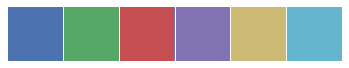

In [26]:
reso=300
current_palette = sns.color_palette()
sns.palplot(current_palette)

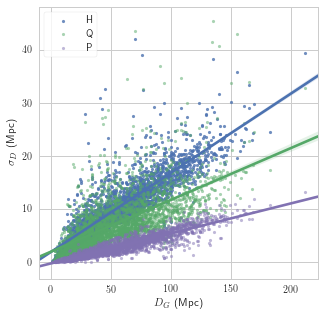

In [172]:
plt.figure(figsize=(5,5))
sns.regplot(x,y,label='H', scatter_kws={'s':10})
sns.regplot(x,qd, scatter_kws={'alpha':0.5,'s':10},label='Q') # green, quadrature
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.5,'s':10},label='P') # red, cosmicflows
#sns.regplot(x,z, scatter_kws={'alpha':0.3}) # purple, mad
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.savefig('mnras/hqp.pdf', dpi=reso,transparent=True)

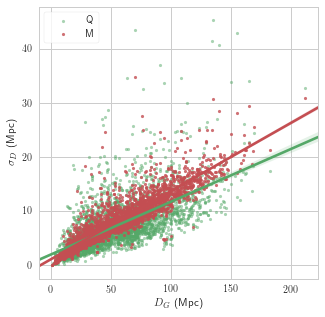

In [173]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1],label='Q', scatter_kws={'alpha':0.5,'s':10})
sns.regplot(x,z,color=current_palette[2],label='M', scatter_kws={'alpha':0.8,'s':10})

plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.savefig('mnras/qm.pdf', dpi=reso,transparent=True)

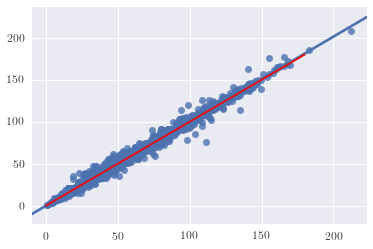

In [5]:
sns.regplot(x,xa)
plt.plot([0,180],[0,180],c='r')

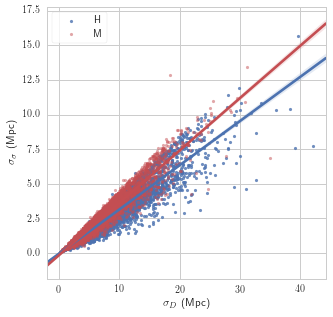

In [176]:
plt.figure(figsize=(5,5))
sns.regplot(y,ee,color=current_palette[0], scatter_kws={'s':10},label='H') # error of the error
sns.regplot(z,ms,color=current_palette[2], scatter_kws={'alpha':0.5,'s':10},label='M') # error of the error

plt.xlabel(r"$\sigma_D$ (Mpc)")
plt.ylabel(r'$\sigma_\sigma$ (Mpc)')
plt.legend(frameon=True)
plt.savefig('mnras/ee.pdf', dpi=reso,transparent=True)

(array([ 110.,  470.,  489.,  450.,  337.,  369.,  346.,  251.,  178.,
         128.,  103.,   67.,   39.,   25.,    8.,   10.,    0.,    1.,
           0.,    1.]),
 array([   0.76083513,   11.34116295,   21.92149077,   32.50181858,
          43.0821464 ,   53.66247421,   64.24280203,   74.82312984,
          85.40345766,   95.98378548,  106.56411329,  117.14444111,
         127.72476892,  138.30509674,  148.88542455,  159.46575237,
         170.04608019,  180.626408  ,  191.20673582,  201.78706363,
         212.36739145]),
 <a list of 20 Patch objects>)

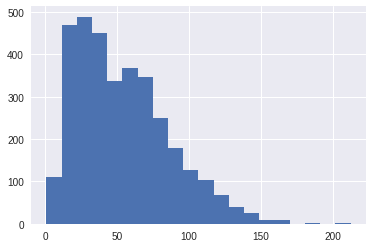

In [24]:
plt.hist(x,bins=20)

# Working Models

## Linear Model

Works for n_meas > 14 (468 galaxies), but discrepancy plot shows different distributions for simulated and observed discrepancies. $\sigma_B$ is the bootstrap-obtained (real) error, $\sigma_{SW}$ is the sigma used for statistical weight in likelihood.

$$\sigma_B=mD+b $$
$$\sigma_{SW}=f\sigma_B$$

We don't like it because it is not super-physical. Also, it's better not to use $\sigma_\sigma$, as we do not have it for empty measurements. We should also look at empty measurements for galaxies that have other measurements.

In [274]:
def lnlike2(theta, x, y):# modelo que usa una fracción de sigma como peso estadistico
    m ,b, f = theta
    model = m * x + b    
    inv_sigma2 = 1.0/((f*model)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior2(theta):
    m, b, f = theta
    if 0 < m < 5 and 0 < b < 2 and 0 < f < 1:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob2(theta, x, y):
    lp = lnprior2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike2(theta, x, y)

def discrep2(ii,samples,x,y):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//100
    for i in range(ndisc):
        yexp=samples[i,0]*x+samples[i,1]
        modpar=samples[np.random.randint(len(samples))]
        ysim=np.random.normal(modpar[0]*x+modpar[1],(modpar[0]*x+modpar[1])*modpar[2])
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
#            yexp=np.sqrt(yexp)
#            ysim=np.sqrt(ysim)
#            y=np.sqrt(y)
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
#        plt.figure(figsize=(6,6))
        plt.scatter(disco,discs,alpha=0.4,label=r"$N>$ "+str(ii)+", Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
        dmax=np.max(np.hstack((disco,discs)))
        dmin=np.min(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax+10,2)
        plt.plot(ppp,ppp,c='r')
#        plt.xlim(dmin,dmax)
#        plt.ylim(dmin,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))
#        return ppp,discs,disco

727
13 0.185513535158 1.02853502984 0.240454060547
13 [ 0.18541763  1.03108542  0.24113989]
Rejection rate = 1 %
Bayesian p-value: 0.956744043358
595
14 0.18746102396 1.03305740388 0.247900825256
14 [ 0.18734114  1.0363949   0.24885503]
Rejection rate = 1 %
Bayesian p-value: 0.871591727544
473
15 0.200660421614 0.759811492237 0.255054433175
15 [ 0.20045099  0.7654275   0.25629016]
Rejection rate = 2 %
Bayesian p-value: 0.557616580311


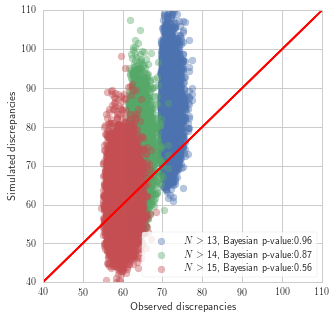

In [299]:
plt.figure(figsize=(5,5))
for i in range(13,16):
    filt=np.array(em)>i
    print(filt.sum())
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]

    nll = lambda *args: -lnlike2(*args)## AQUI
    result = op.minimize(nll, [1.]*3, args=(x, y)) ## AQUI
    m_ml, b_ml,f_ml = result["x"]## AQUI
    print(i,m_ml,b_ml,f_ml)## AQUI
    #    if b_ml > 0:
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(x, y)) ## AQUI
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    steps=10000
    sampler.run_mcmc(pos, steps);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    sth=samples.mean(axis=0)
#    fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
    print(i,sth)
    discrep2(i,samples,x,y)
plt.legend(loc='lower right',frameon=True)
plt.xlabel('Observed discrepancies')
plt.ylabel('Simulated discrepancies')
plt.xlim(40,110)
plt.ylim(40,110)
plt.savefig('mnras/discl.pdf', dpi=reso,transparent=True)

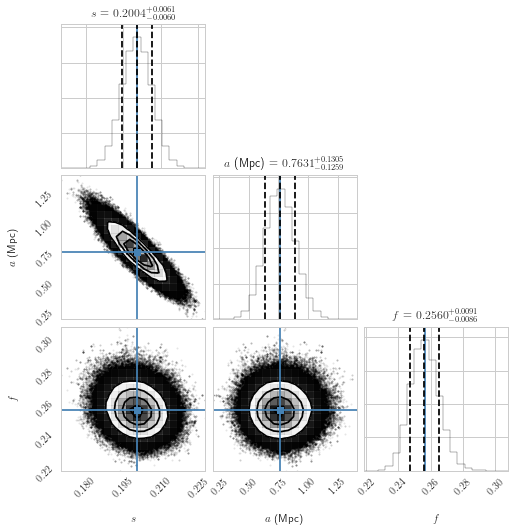

In [300]:
fig = corner.corner(samples, labels=["$s$", "$a$ (Mpc)","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
plt.savefig('mnras/cornerl.pdf', dpi=reso,transparent=True)

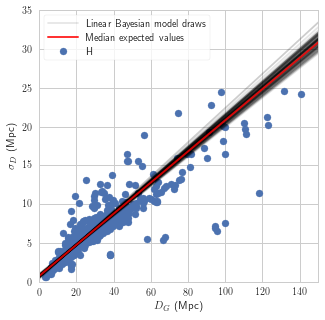

In [295]:
plt.figure(figsize=(5,5))
xl = np.linspace(0,160,2)
sth=np.median(samples,axis=0)
plt.figure(figsize=(5,5))
for m, b,f in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m*xl+b, color="k", alpha=0.1,label="Linear Bayesian model draws")
plt.scatter(x,y,label='H')
plt.plot(xl, sth[0]*xl+sth[1], color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,150)
plt.ylim(0,35)
plt.savefig('mnras/drawsl.pdf', dpi=reso,transparent=True)

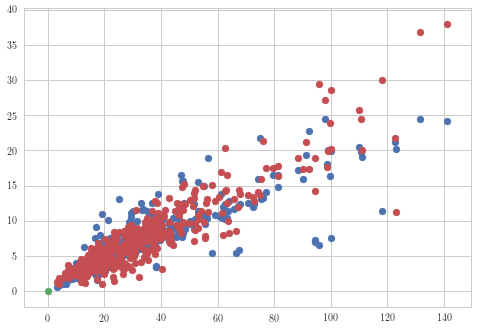

In [228]:
modpar=samples[np.random.randint(len(samples))]
ysim=np.random.normal(modpar[0]*x+modpar[1],modpar[2]*(modpar[0]*x+modpar[1]))
plt.scatter(x,y)
plt.scatter([0],[0])
plt.scatter(x,ysim)

39.3634689641 9.86846725598
39.740863478 10.3358734451
38.6818842473 10.042006284


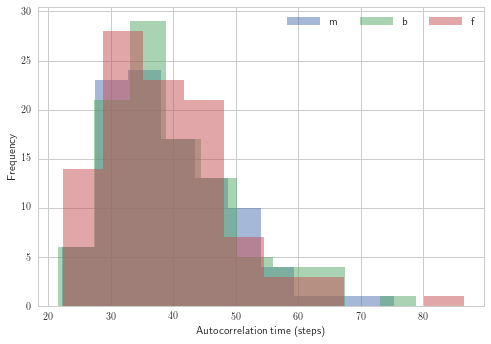

In [281]:
for j in range(3):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ['m','b','f'],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

In [ ]:
plt.figure(figsize=(5,5))
for i in range(11,14):
    filt=np.array(em)>i
    print(filt.sum())
    x=np.array(dboot)[filt]
    y=np.array(bootmad)[filt]

    nll = lambda *args: -lnlike2(*args)## AQUI
    result = op.minimize(nll, [1.]*3, args=(x, y)) ## AQUI
    m_ml, b_ml,f_ml = result["x"]## AQUI
    print(i,m_ml,b_ml,f_ml)## AQUI
    #    if b_ml > 0:
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(x, y)) ## AQUI
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    steps=10000
    sampler.run_mcmc(pos, steps);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    sth=samples.mean(axis=0)
    #fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
    print(i,sth)
    discrep2(i,samples,x,y)
plt.legend(loc='lower right')
plt.xlabel('Observed discrepancies')
plt.ylabel('Simulated discrepancies')
plt.xlim(40,120)
plt.ylim(40,120)
plt.savefig('mnras/discl2.pdf', dpi=reso,transparent=True)

1175
11 0.139036160764 0.607727724318 0.216737687043


In [ ]:
fig = corner.corner(samples, labels=["$s$", "$a$ (Mpc)","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
plt.savefig('mnras/cornerl2.pdf', dpi=reso,transparent=True)

In [ ]:
plt.figure(figsize=(5,5))
xl = np.linspace(0,160,2)
sth=np.median(samples,axis=0)

for m, b,f in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m*xl+b, color="k", alpha=0.1,label="Linear Bayesian model draws")
plt.scatter(x,y,label='M')
plt.plot(xl, sth[0]*xl+sth[1], color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,150)
plt.ylim(0,25)
plt.savefig('mnras/drawsl2.pdf', dpi=reso,transparent=True)

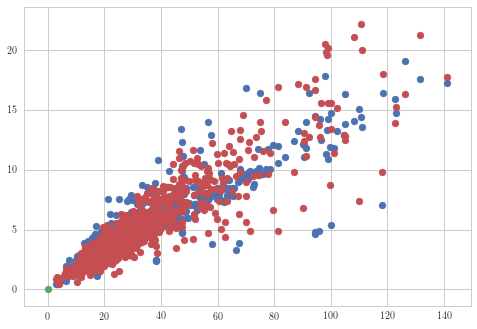

In [233]:
modpar=samples[np.random.randint(len(samples))]
ysim=np.random.normal(modpar[0]*x+modpar[1],modpar[2]*(modpar[0]*x+modpar[1]))
plt.scatter(x,y)
plt.scatter([0],[0])
plt.scatter(x,ysim)

37.9219577972 8.65518374237
37.9263070078 7.5611755627
40.0596392275 9.2995938277


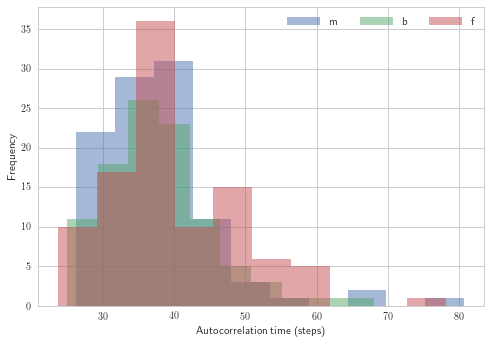

In [286]:
for j in range(3):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ['m','b','f'],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

## Quadrature

$$\sigma_D=\sqrt{(mD+c)^2+b^2 }$$
$$\sigma_{SW}=f\sigma_D$$
Quadrature model with multiplicative and additive terms in systematic error. It shows numerical instability due to the degeneracy between the zero offset error and the random error.


If an additive term is added to the systematic error, we go back to the linear model, as $b$ goes to zero in the MCMC.

In [287]:
def lnlike4(theta, x, y):# modelo que usa una fracción de sigma_sigma
    m ,b,f,c = theta
    model = np.sqrt((m*x+c)**2+ b**2)
    inv_sigma2 = 1.0/(f*model)**2
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior4(theta):
    m, b, f,c = theta
    if 0 < m < 1 and -10 < b < 10 and 0 < f < 1 and 0 < c < 10:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob4(theta, x, y):
    lp = lnprior4(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike4(theta, x, y)

def discrep4(ii,samples,x,y):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//100
    for i in range(ndisc):
        yexp=(samples[i,0]*x+samples[i,3])**2+samples[i,1]**2
        yexp=np.sqrt(yexp)
        modpar=samples[np.random.randint(len(samples))]
        ymod=(modpar[0]*x+modpar[3])**2+modpar[1]**2
        ymod=np.sqrt(ymod)
        ysim=np.random.normal(ymod,modpar[2]*ymod)
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1
        else:        
#            ysim=np.sqrt(ysim)
#            y=np.sqrt(y)
#            discs+=[((ysim-yexp)**2).sum()]
#            disco+=[((y-yexp)**2).sum()]
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.scatter(disco,discs,alpha=0.4,label=r"$N>$ "+str(ii)+", Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
        dmax=np.max(np.hstack((disco,discs)))
        dmin=np.min(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax+10,2)
        plt.plot(ppp,ppp,c='r')
#        plt.xlim(dmin,dmax)
#        plt.ylim(dmin,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

69
23 0.229056202783 -2.02771906639e-07 0.247664874657 0.514031842813
23 [ 0.2247663  -0.0092781   0.25686564  0.50551878]
Rejection rate = 0 %
Bayesian p-value: 0.045845856044
48
24 0.253686376524 -5.16539967972e-08 0.252215341277 0.185607102276
24 [ 0.23360338 -0.00091782  0.26647551  0.43847399]
Rejection rate = 1 %
Bayesian p-value: 0.116425071458
29
25 0.265260662006 -3.67596973305e-06 0.224478085503 0.201414884943
25 [ 0.23456107 -0.0057512   0.24595905  0.57866286]
Rejection rate = 0 %
Bayesian p-value: 0.734798497614


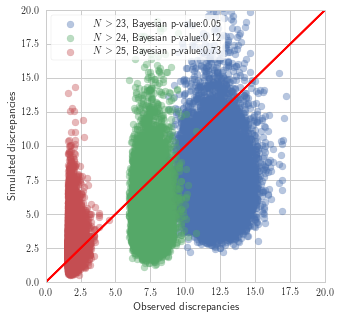

In [288]:
plt.figure(figsize=(5,5))
for i in range(23,26):
    filt=np.array(em)>i
    print(filt.sum())
    xx=np.array(dboot)[filt]
    yy=np.array(bootp50)[filt]
    #y=np.array(bootmad)[filt]
    #yy=yy**2
    nll = lambda *args: -lnlike4(*args)## AQUI
    result = op.minimize(nll, [1.]*4, args=(xx, yy)) ## AQUI
    m_ml, b_ml,f_ml,c_ml = result["x"]## AQUI
    print(i,m_ml,b_ml,f_ml,c_ml)## AQUI
    #    if b_ml > 0:
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    samplerq = emcee.EnsembleSampler(nwalkers, ndim, lnprob4, args=(xx, yy)) ## AQUI
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    steps=20000
    samplerq.run_mcmc(pos, steps);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samplesq = samplerq.chain[:, 200:, :].reshape((-1, ndim)) 
    sthq=samplesq.mean(axis=0)
#    fig = corner.corner(samplesq, labels=["$s^2$", "$\sigma_r$ (Mpc)","$f$","$a$ (Mpc)"],truths=sthq, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
    print(i,sthq)
    discrep4(i,samplesq,xx,yy)
plt.legend(loc='upper left',frameon=True)
plt.xlabel('Observed discrepancies')
plt.ylabel('Simulated discrepancies')
plt.xlim(0,20)
plt.ylim(0,20)
plt.savefig('mnras/discq.pdf', dpi=reso,transparent=True)

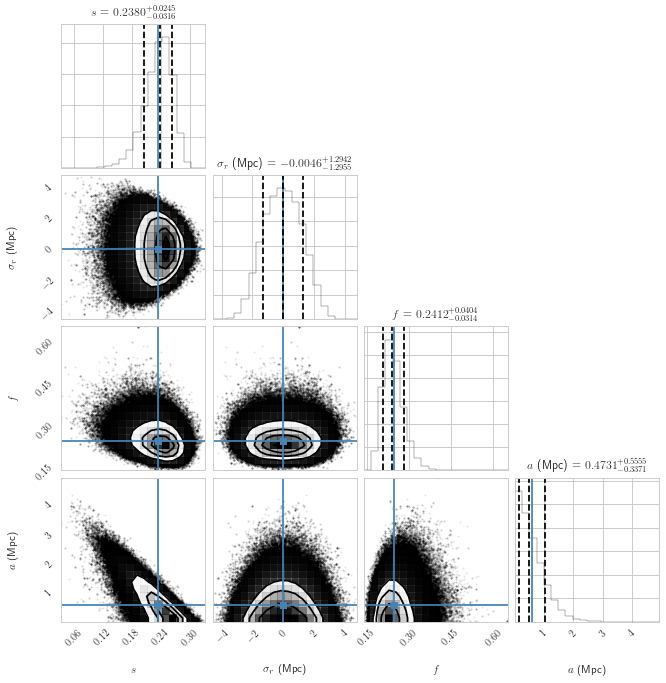

In [289]:
fig = corner.corner(samplesq, labels=["$s$", "$\sigma_r$ (Mpc)","$f$","$a$ (Mpc)"],truths=sthq, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
plt.savefig('mnras/cornerq.pdf', dpi=reso,transparent=True)

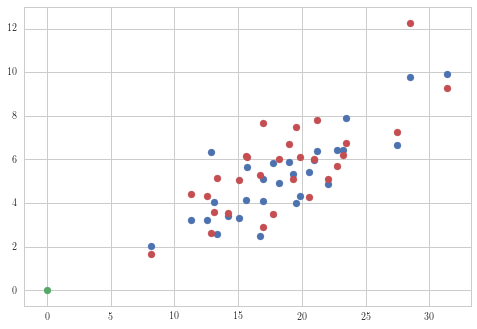

In [224]:
modparq=samplesq[np.random.randint(len(samplesq))]
ymod=np.sqrt((modparq[0]*xx+modparq[3])**2+modparq[1]**2)
ysim=np.random.normal(ymod,modparq[2]*ymod)
plt.scatter(xx,yy)
plt.scatter([0],[0])
plt.scatter(xx,ysim)

62.6686438992 10.9713686185
86.7087838729 15.9718456084
59.3360377746 8.84547630071
65.9754235963 15.7099277113


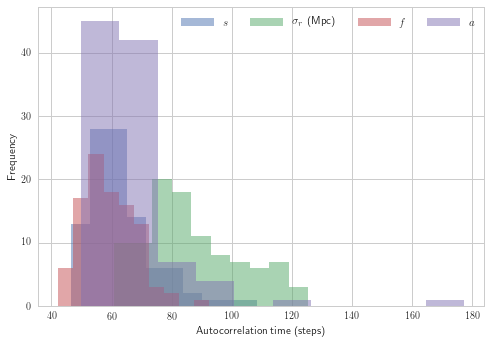

In [291]:
for j in range(4):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(samplerq.chain[i,:,j],c=3))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ["$s$", r"$\sigma_r$ (Mpc)","$f$","$a$"],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

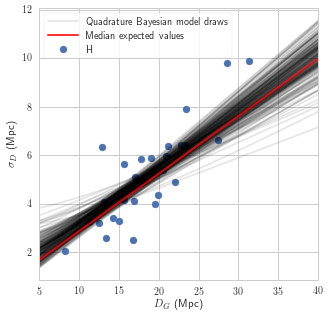

In [292]:
plt.figure(figsize=(5,5))
plt.scatter(xx,yy,label="H")
xl = np.linspace(5,40,2000)
sthq=np.median(samplesq,axis=0)

for m, b,f,c in samplesq[np.random.randint(len(samplesq), size=200)]:
    plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1)
plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1,label="Quadrature Bayesian model draws")
plt.plot(xl, np.sqrt((sthq[0]*xl+sthq[3])**2+sthq[1]**2), color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(5,40)
plt.savefig('mnras/drawsq.pdf', dpi=reso,transparent=True)

921
12 0.141500005784 4.8439344709e-08 0.225559697414 0.545307176212
12 [  1.41494027e-01   4.22175983e-04   2.26252739e-01   5.41155777e-01]
Rejection rate = 0 %
Bayesian p-value: 0.939680602177
727
13 0.141714717192 -9.6389619157e-08 0.227190004661 0.527438249239
13 [ 0.14175678 -0.00061673  0.2280447   0.52062735]
Rejection rate = 0 %
Bayesian p-value: 0.591888595243


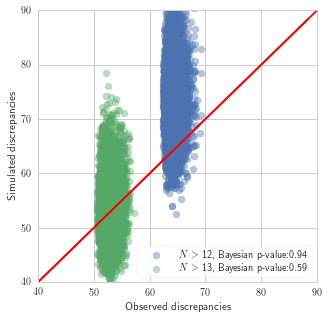

In [260]:
plt.figure(figsize=(5,5))
for i in range(12,14):
    filt=np.array(em)>i
    print(filt.sum())
    xx=np.array(dboot)[filt]
#    yy=np.array(bootp50)[filt]
    yy=np.array(bootmad)[filt]
    #yy=yy**2
    nll = lambda *args: -lnlike4(*args)## AQUI
    result = op.minimize(nll, [1.]*4, args=(xx, yy)) ## AQUI
    m_ml, b_ml,f_ml,c_ml = result["x"]## AQUI
    print(i,m_ml,b_ml,f_ml,c_ml)## AQUI
    #    if b_ml > 0:
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    samplerq = emcee.EnsembleSampler(nwalkers, ndim, lnprob4, args=(xx, yy)) ## AQUI
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    steps=10000
    samplerq.run_mcmc(pos, steps);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samplesq = samplerq.chain[:, 120:, :].reshape((-1, ndim)) 
    sthq=samplesq.mean(axis=0)
#    fig = corner.corner(samplesq, labels=["$s^2$", "$\sigma_r$ (Mpc)","$f$","$a$ (Mpc)"],truths=sthq, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
    print(i,sthq)
    discrep4(i,samplesq,xx,yy)
plt.legend(loc='lower right',frameon=True)
plt.xlabel('Observed discrepancies')
plt.ylabel('Simulated discrepancies')
plt.xlim(40,90)
plt.ylim(40,90)
plt.savefig('mnras/discq2.pdf', dpi=reso,transparent=True)

47.6705048182 14.5444345911
47.4429169466 11.857329259
47.9801135469 12.3818186798
47.5312827286 11.5223606052


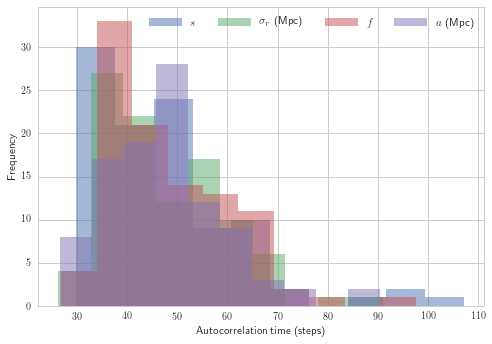

In [262]:
for j in range(4):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(samplerq.chain[i,:,j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ["$s$", r"$\sigma_r$ (Mpc)","$f$","$a$ (Mpc)"],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

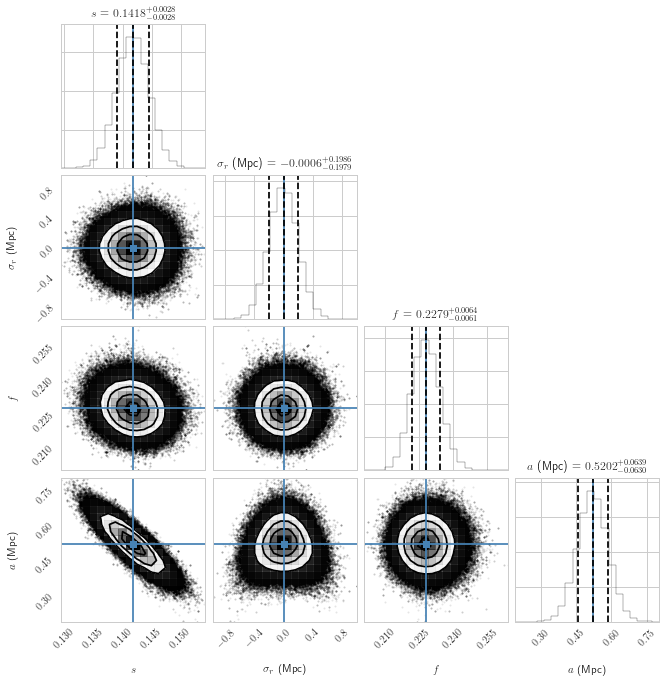

In [263]:
fig = corner.corner(samplesq, labels=["$s$", "$\sigma_r$ (Mpc)","$f$","$a$ (Mpc)"],truths=sthq, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
plt.savefig('mnras/cornerq2.pdf', dpi=reso,transparent=True)

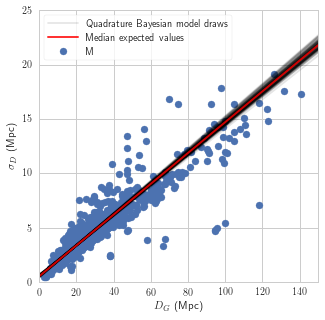

In [268]:
plt.figure(figsize=(5,5))
plt.scatter(xx,yy,label="M")
sthq=np.median(samplesq,axis=0)
xl = np.linspace(0,150,200)
for m, b,f,c in samplesq[np.random.randint(len(samplesq), size=100)]:
    plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1)
plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1,label="Quadrature Bayesian model draws")
plt.plot(xl, np.sqrt((sthq[0]*xl+sthq[3])**2+sthq[1]**2), color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,150)
plt.ylim(0,25)
plt.savefig('mnras/drawsq.pdf', dpi=reso,transparent=True)

(0, 70)

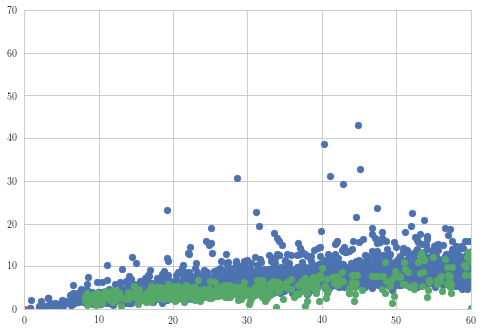

In [158]:
# funciona para el rango (modelo cuadratico)
# probar con los demás modelos
# ver que predice para otros
i=2
mxlim=60
filt=np.array(em)>i
xt=np.array(dboot)[filt]
yt=np.array(bootp50)[filt]
xli=dista # replace with dista
xli=xli[(xli<=60)&(xli>=x.min())]
# is this the best way to generate synthetic data? I don't remember, look at discrepancies
ysli=np.random.normal(modpar[0]*xli**2+modpar[1]**2,modpar[2]*(modpar[0]*xli**2+modpar[1]**2))
plt.scatter(xt,yt) # azules, todos los datos con nmeas >2
plt.scatter(xli,ysli) # verdes, datos sintéticos

#plt.scatter(x,y) # datos usados por el modelo
plt.scatter([0],[0])
plt.xlim(0,mxlim) 
plt.ylim(0,70)

In [159]:
((xli<=30)&(xli>=x.min())).sum()

289

In [253]:
df.head()

,bootmad,bootp50,bootsig,dboot,dwa,ecf,eqd,meas,names,wsnt
0,14.334875,16.160127,6.377554,77.115770,77.014985,7.445804,16.507959,5,UGC 12889,14.733387
1,6.989973,6.531578,3.254346,55.987229,54.945512,3.875843,9.597371,3,KUG 2357+228,8.779942
2,9.778287,4.784260,4.388478,66.647457,65.883411,10.216632,10.220920,2,2MFGC 00003,0.296010
3,9.103637,8.625469,5.385361,78.498899,76.317265,6.028933,8.538490,3,UGC 12898,6.046302
4,17.030606,19.317917,7.768481,128.972827,129.193018,9.276907,11.487566,7,UGC 12897,6.775187


In [254]:
ddf=pd.read_csv("NED27.09.1-D-14.2.0-20170929.csv",skiprows=12)
ddf=ddf[np.isnan(ddf['redshift (z)'])]

In [261]:
odf=ddf[np.in1d(ddf['Galaxy ID'],nulista)]
mydf=odf[odf.Method=='Tully-Fisher']

In [263]:
mydf.head()

,Exclusion Code,D,G,Galaxy ID,m-M,err,D (Mpc),Method,REFCODE,SN ID,redshift (z),Hubble const.,Adopted LMC modulus,Date (Yr. - 1980),Notes
47,NaN,37,23,UGC 12894,29.64,NaN,8.47,Tully-Fisher,2013AJ....145..101K,NaN,NaN,NaN,NaN,33,NaN
298,R,259,125,WLM,25.88,NaN,1.50,Tully-Fisher,2006sf2a.conf..365V,NaN,NaN,NaN,NaN,26,LEDA [April 2006]
692,NaN,576,260,FGC 0001,32.70,NaN,34.70,Tully-Fisher,2000BSAO...50....5K,NaN,NaN,NaN,NaN,20,NaN
693,NaN,577,260,FGC 0001,33.19,NaN,43.50,Tully-Fisher,2010Ap&SS.325..163P,NaN,NaN,NaN,NaN,30,Dipole + Quadrupole + Octopole
694,NaN,578,260,FGC 0001,33.21,NaN,43.90,Tully-Fisher,2010Ap&SS.325..163P,NaN,NaN,NaN,NaN,30,Dipole + Quadrupole


In [264]:
meddist=[]
for i in nulista:
    dummy=mydf[mydf['Galaxy ID']==i]
    meddist+=[np.median(dummy['D (Mpc)'])]

In [270]:
meddist=np.array(meddist)
len(meddist)


818

(array([ 318.,  180.,  126.,   84.,   42.,   31.,   25.,    9.,    0.,    3.]),
 array([  7.66000000e-02,   2.70689400e+01,   5.40612800e+01,
          8.10536200e+01,   1.08045960e+02,   1.35038300e+02,
          1.62030640e+02,   1.89022980e+02,   2.16015320e+02,
          2.43007660e+02,   2.70000000e+02]),
 <a list of 10 Patch objects>)

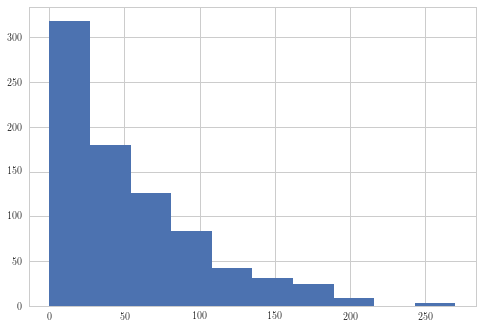

In [267]:
plt.hist(meddist)

In [273]:
x.min()

2.8327613702075238

In [276]:
((meddist<150)&(meddist>2)).sum()

766

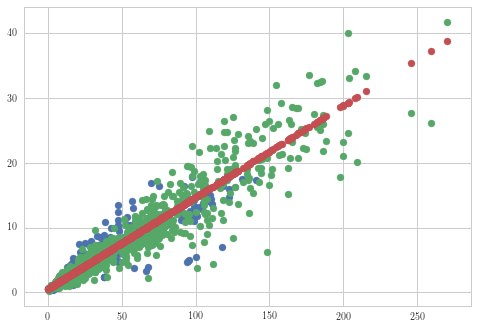

In [293]:
plt.scatter(x,y)
modpar=samples[np.random.randint(len(samples))]
ysim=np.random.normal(modpar[0]*meddist+modpar[1],modpar[2]*(modpar[0]*meddist+modpar[1]))
plt.scatter(meddist,ysim)
plt.scatter(meddist,meddist*sth[0]+sth[1])


In [ ]:
plt.scatter()